In [1]:
#using Pkg
#Pkg.add("Chain")
#Pkg.add("DataFrames")
#Pkg.add("CSV")
#Pkg.add("Statistics")
using DataFrames, CSV, Statistics, Chain
using Distributions,Optim, Plots
dataset = CSV.read("datamerged2.csv", DataFrame);

# The Estimation Plan

Collect the data from all the offers in treatment 1 (no lower bounde on offers).  Use only the data from round 2, where all the players are supposed to be experienced.  Convert multiple offers from each principle into a single offer by taking their average. Convert all of the responses from the same responder and find the lowest offer they accepted.  (This ignores cases where a reponder rejected a particular offer, then later accepted a lower one).  Convert this into a pair of vectors to be fed as data to a likelihood function.

Use a truncated normal distribution with a lower truncation point at 1, with no upper truncation point to represent the distribution of loss aversion parameters.  We'll try to estimate its mean and variance.

Construct the likelihood function and code it.

Use the optim solver to minimize the negative of the log of the likelihood function to estimate the mean and variance of the distribution, the reservation value $r$, and the spitefulness parameter $\alpha$.

In [2]:
describe(dataset)  ## summarize the dataset

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,id,136.852,1,133.0,276,0,Int64
2,treatment,2.42475,1,3.0,4,0,Int64
3,tofrom,144.308,6,145.0,288,0,Int64
4,value,18.7922,0.0,20.0,49.0,0,Float64
5,role,0.0,0,0.0,0,0,Int64
6,resp,0.81462,0,1.0,1,0,Int64
7,round,1.60774,1,2.0,3,0,Int64
8,rounds,2.215,2,2.0,3,0,Int64
9,old,0.701386,0,1.0,2,0,Int64


In [3]:
#filter the dataframe to find all the rows associated with treatment 1 round2
# group these rows by theh proposer id
# combine the grouped rows then take the mean offer in each row
## this leaves 55 observations (that is, 55 different proposers)
## the chain package above is used to convert tows of a dataframe into a vector (probably there are better ways to do this)
r0 = filter( row -> row.round == 2 && row.treatment ==1, dataset);
subset = groupby(r0, :id);
offs = combine(subset, :value => mean);
offers = @chain offs begin
    _.value_mean
end;

In [4]:
# repeat the operation abouve by filter out all the rejects, group by tofrom (thatis, the responders), group them then apply the minimum operation across each group
r1 = filter( row -> row.resp == 1, r0);
r = groupby(r1, :tofrom);
resp = combine(r, :value => minimum);
responses = @chain resp begin
   _.value_minimum
end;

# The likelihood function
Let $s_i$ be the 'offer' made by proposer $i$, and $\underline{s}_j$ the lowest offer accepted by responder $j$.  Then define
$\mathcal{L}(G,r,\alpha)$ to be equal to 
$$
\prod_i \biggl\{ G^\prime(\frac{2Q(s_i)(1+2\alpha)}{Q^\prime(s_i)} - 2(1-s_i(1+2\alpha)) + 1)\biggr\} \times \prod_j\biggl\{1 - G\left(\frac{r-\underline{s}_j+\frac{1}{2}}{r}\right)\biggr\}
$$

In this expression 
$$
1-G(\frac{r-s+\frac{1}{2}}{r}) = Q(s)
$$
whenever $s \ge r$ while
for $s<r$  
$$
Q(s) = 1-G(\frac{1}{2s}).
$$

To estimate the distribution of loss aversion parameters we'll use a parametric distribution function.  Specificall, the truncated normal distribution.  This comes from the `Distributions` library loaded above.  The lower truncation point is 1 as the loss aversion type has a lower bound at 1.  There is no reason to impose any upper limit at this point so we use `Inf`. If you'd like to look at the distribution, uncomment the plot command after the definition.

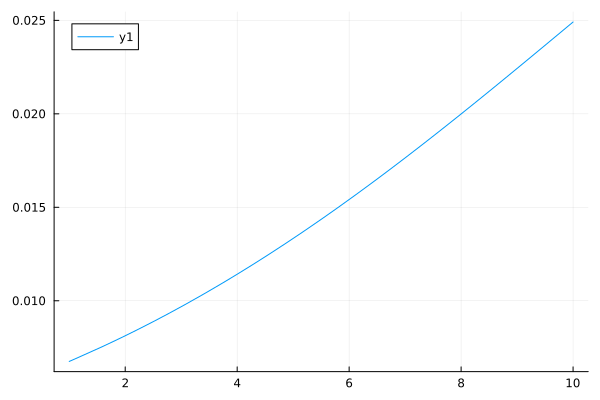

In [5]:
G = TruncatedNormal(20, 10,1, Inf)
plot(x -> pdf(G,x),1,10)

In [6]:
median(G)

20.359986440026713

In [7]:
#initialize
mu = 20 # mean for the distribution
sigma = 10 #variance
r = 2
K = 55
R = .5*K
alpha = 1/10

0.1

In [8]:
params = [mu, sigma, r, alpha]
params[1]

20.0

The next functions give the probability of acceptance and its derivative.  The distribution functions depend on paramenters, so they are passed as arguments.  Make sure your functions assign values for all input arguments to prevent the likelihood compuation from looking out of bounds.  Especially, watch for zeros in denominators.


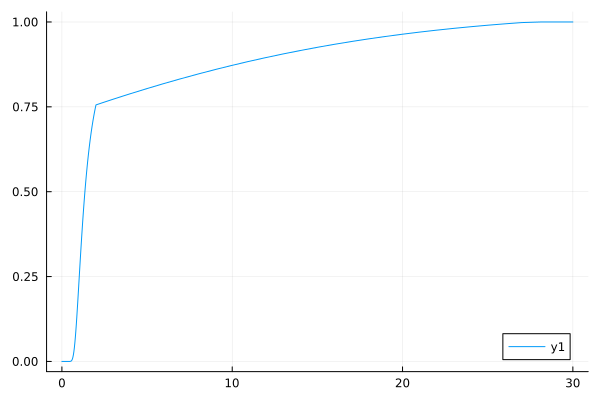

In [9]:
function Q(s, r, G,K)
    if s >= K/2
        return 1
    elseif s <= 0
        return 0
    elseif r <= 0
        return 0
    elseif s >= r
        return 1 - cdf(G, (r-s+K/2)/r)
    else
        return 1- cdf(G, K/(2*s))
    end
end
plot(x -> Q(x,r,G,K),0,30)


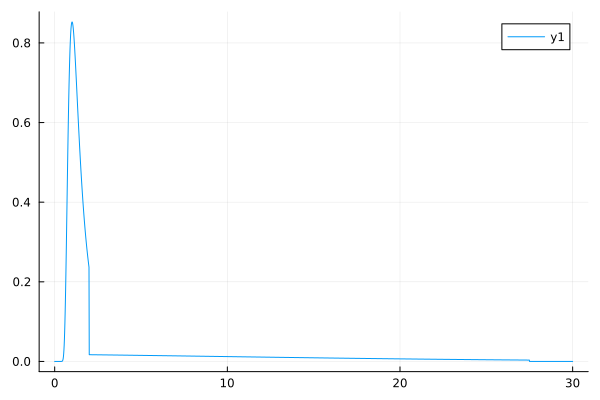

In [10]:
function dQ(s, r, G, K)
      if s >= K/2
        return 0
    elseif s <= 0
        return 0
    elseif r <= 0
        return 0
    elseif s >= r
        return  pdf(G, (r-s+K/2)/r)*1/r
    else
        return pdf(G, K/(2*s))*K/(2*s^2)
    end
end

plot(x -> dQ(x,r,G, K),0,30)


The next bit we need to code is the calculation of the 'probability' of a proposer's offer.  As above, the loss aversion parameter of a proposer who offers $s$ is given by
$$
\lambda = \left( \frac{Q(s)(1-2\alpha)}{RQ^\prime (s)} -\frac{K}{R}(1+\alpha) + 1 +s\frac{1+2\alpha}{R} \right) 
$$



Before we get to this function, notice that there is a $Q^\prime$ in the denominator of the first term in this expression. If you looked at plots of the $Q$ function above you will notice there are flat spots we'll need to deal with.  To do this, notice that offers at or above $\frac{1}{2}$ are always accepted.

There are actually a lot of proposer types whose loss aversion parameter is so high, they will optimally make an offer of $\frac{1}{2}$ or even higher if they make a mistake (there was one offer of 49, which probably means the proposer didn't understand the payoff function).  So there is some pooling.  

The way we'll deal with this is to treat all offers above $\frac{55}{2}$ as if they were made by proposers who want their offer to be accepted for sure.  So the distribution of offers will have a mass point at $\frac{55}{2}$.

Similarly, you'll notice that the probability of acceptance function has a 'kink' at the reference point $r$, which means there will also be a mass point there.  To find a likelihood we'll have to calculate these masses.  The probabilities for all the other offers will be represented by densities.

We next need to calculate the size of these mass points.



In [11]:
function type(s, r, G, alpha, K,R)
    return max(1,Q(s,r,G,K)*(1+2*alpha)/(R*dQ(s,r,G,K)) -(K/R)*(1+alpha)+ 1 + s*(1+2*alpha)/R)
end


type (generic function with 1 method)

In [12]:
type(r,r,G,alpha,K,R)

1.0

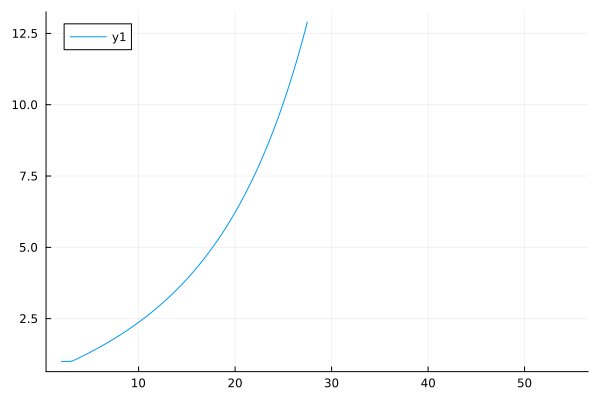

In [13]:
plot(x -> type(x,r,G,alpha,K,R),r,K)

We next need to worry about a potential mass point at $\frac{K}{2}$  This won't exist here because all of our proposer types know that is a dominated strategy.  For example

In [14]:
at_one = 1- cdf(G,type(K/2,r,G,alpha,K,R))
#should be zero because there are no types high enough to do this.

0.0

At the other extreme, there is potentially a mass point at the reserve value.  Again this is easy. Check the type who offers $r$ then find the cdf.  That will be the mass of types you want.  With the parameters we are using for this demonstration, there are no such types because the lowest type in the support of our truncated disribution wants to offer more.

In [15]:
function at_r(r,G,alpha,K,R)
    return max(cdf(G,type(r,r,G,alpha,K,R)),0)
end

at_r (generic function with 1 method)

In [16]:
at_r(r,G,alpha,K,R)

0.0

A data check.

In [17]:
if length(responses) != length(offers)
    println("A data error - there are a different number of proposers and responders.  Possibly some responder rejected all offers, but more likely something wrong")
else
    println("Data Good")
end   

Data Good


In [21]:
function likelihood(params, offers, responses,K,R)
    G = TruncatedNormal(params[1],params[2],1, Inf)
    l = 0
    for o in offers
        if o <= params[3]
            v = at_r(params[3],G,params[4],K,R)
            if v > 0
                l += log(v)
            else 
                l += log(.01)
            end
        else
            v = pdf(G,type(o,params[3],G,params[4],K,R))
            if v > 0
                l += log(v)
            else
                l += log(.01)
            end
        end
    end
    for k in responses
        l += log(1 - cdf(G, (params[3]-k+K/2)/params[3])+.01)
    end
    return -l
end
            
    

likelihood (generic function with 1 method)

In [22]:
likelihood(params, offers,responses,K,R)

236.63414289704372

In [42]:
lower = [5,5,1.5,0]
upper = [Inf, Inf,2.5,5]
initial = [mu,sigma,2,.1]

4-element Vector{Float64}:
 20.0
 10.0
  2.0
  0.1

In [43]:
res = optimize(params -> likelihood(params, offers, responses,K,R), lower, upper, initial, Fminbox())

 * Status: success

 * Candidate solution
    Final objective value:     1.813065e+02

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 6.30e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.00e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.30e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    302
    ∇f(x) calls:   302


In [44]:
result = Optim.minimizer(res)

4-element Vector{Float64}:
 5.000000005302506
 6.5083922645353836
 2.4999999995868305
 2.715603882235478

In [45]:
likelihood(result, offers,responses,K,R)

181.30653270277654